# Compass recidivism

## Import

In [1]:
import pandas as pd
import matplotlib as plt
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
import shap

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
df = pd.read_csv("src/compas-scores-raw.csv")

## Data analysis

In [3]:
df.head()

,Person_ID,AssessmentID,Case_ID,Agency_Text,LastName,FirstName,MiddleName,Sex_Code_Text,Ethnic_Code_Text,DateOfBirth,...,RecSupervisionLevel,RecSupervisionLevelText,Scale_ID,DisplayText,RawScore,DecileScore,ScoreText,AssessmentType,IsCompleted,IsDeleted
0,50844,57167,51950,PRETRIAL,Fisher,Kevin,NaN,Male,Caucasian,12/05/92,...,1,Low,7,Risk of Violence,-2.08,4,Low,New,1,0
1,50844,57167,51950,PRETRIAL,Fisher,Kevin,NaN,Male,Caucasian,12/05/92,...,1,Low,8,Risk of Recidivism,-1.06,2,Low,New,1,0
2,50844,57167,51950,PRETRIAL,Fisher,Kevin,NaN,Male,Caucasian,12/05/92,...,1,Low,18,Risk of Failure to Appear,15.00,1,Low,New,1,0
3,50848,57174,51956,PRETRIAL,KENDALL,KEVIN,NaN,Male,Caucasian,09/16/84,...,1,Low,7,Risk of Violence,-2.84,2,Low,New,1,0
4,50848,57174,51956,PRETRIAL,KENDALL,KEVIN,NaN,Male,Caucasian,09/16/84,...,1,Low,8,Risk of Recidivism,-1.50,1,Low,New,1,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60843 entries, 0 to 60842
Data columns (total 28 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Person_ID                60843 non-null  int64  
 1   AssessmentID             60843 non-null  int64  
 2   Case_ID                  60843 non-null  int64  
 3   Agency_Text              60843 non-null  object 
 4   LastName                 60843 non-null  object 
 5   FirstName                60843 non-null  object 
 6   MiddleName               15624 non-null  object 
 7   Sex_Code_Text            60843 non-null  object 
 8   Ethnic_Code_Text         60843 non-null  object 
 9   DateOfBirth              60843 non-null  object 
 10  ScaleSet_ID              60843 non-null  int64  
 11  ScaleSet                 60843 non-null  object 
 12  AssessmentReason         60843 non-null  object 
 13  Language                 60843 non-null  object 
 14  LegalStatus           

In [5]:
df.describe()

,Person_ID,AssessmentID,Case_ID,ScaleSet_ID,RecSupervisionLevel,Scale_ID,RawScore,DecileScore,IsCompleted,IsDeleted
count,60843.000000,60843.000000,60843.000000,60843.000000,60843.000000,60843.000000,60843.000000,60843.000000,60843.0,60843.0
mean,53683.206154,68061.029190,60209.128149,21.819536,1.630048,11.000000,5.081457,3.571701,1.0,0.0
std,14363.648515,7320.208226,9638.501654,0.932614,0.944220,4.966596,10.080518,2.617854,0.0,0.0
min,656.000000,649.000000,350.000000,17.000000,1.000000,7.000000,-4.790000,-1.000000,1.0,0.0
25%,52039.000000,62582.000000,56021.000000,22.000000,1.000000,7.000000,-2.090000,1.000000,1.0,0.0
50%,57321.000000,68229.000000,61261.000000,22.000000,1.000000,8.000000,-0.710000,3.000000,1.0,0.0
75%,62748.000000,73870.000000,66554.000000,22.000000,2.000000,18.000000,14.000000,5.000000,1.0,0.0
max,68608.000000,79678.000000,72045.000000,22.000000,4.000000,18.000000,51.000000,10.000000,1.0,0.0


In [6]:
df['Ethnic_Code_Text'] = df['Ethnic_Code_Text'].replace('African-Am', 'African-American')

<AxesSubplot:xlabel='Ethnic_Code_Text'>

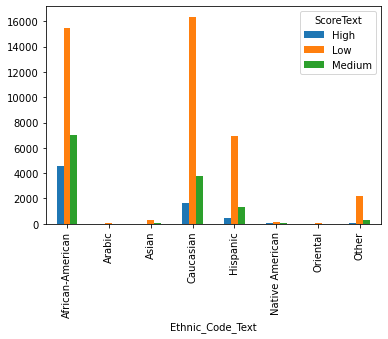

In [7]:
text_by_race = df.groupby(['Ethnic_Code_Text', 'ScoreText'], sort=True)['Person_ID'].size()
text_by_race.unstack().plot.bar(stacked=False)

In [8]:
text_by_race = df.groupby(['Ethnic_Code_Text', 'ScoreText'], sort=True).size().reset_index()
text_by_race = text_by_race.rename(columns={0:'count'})
text_by_race[['count']] = text_by_race[['count']].apply(pd.to_numeric)
gb = df.groupby(['Ethnic_Code_Text']).size().reset_index()
gb_d = gb.set_index('Ethnic_Code_Text').to_dict().get(0)
text_by_race['count_percentage'] = text_by_race.apply(lambda x: ((int(x['count'])/int(gb_d.get(x['Ethnic_Code_Text']))) * 100), axis=1)
text_by_race

,Ethnic_Code_Text,ScoreText,count,count_percentage
0,African-American,High,4560,16.845838
1,African-American,Low,15485,57.205660
2,African-American,Medium,7008,25.889394
3,Arabic,High,5,6.666667
4,Arabic,Low,58,77.333333
5,Arabic,Medium,12,16.000000
6,Asian,High,14,4.320988
7,Asian,Low,278,85.802469
8,Asian,Medium,32,9.876543
9,Caucasian,High,1648,7.565533


ScoreText  RecSupervisionLevelText           
High       High                                   2984
           Low                                     327
           Medium                                  352
           Medium with Override Consideration     3160
Low        High                                    718
           Low                                   34362
           Medium                                 4326
           Medium with Override Consideration     2081
Medium     High                                    366
           Low                                    3744
           Medium                                 5793
           Medium with Override Consideration     2585
Name: Person_ID, dtype: int64

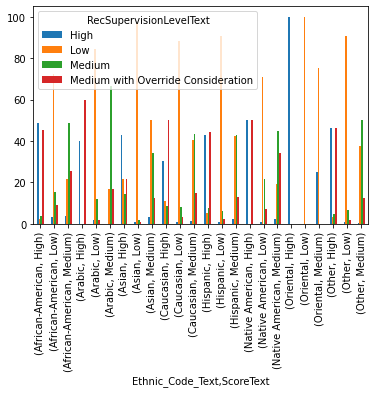

In [9]:
text_by_race['count_percentage'] = text_by_race.apply(lambda x: ((int(x['count'])/int(gb_d.get(x['Ethnic_Code_Text']))) * 100), axis=1)
recid_by_race = df.groupby(['Ethnic_Code_Text', 'ScoreText', 'RecSupervisionLevelText'], sort=True).size().reset_index()
recid_by_race = recid_by_race.rename(columns={0:'count'})
r_sum = df.groupby(['Ethnic_Code_Text', 'ScoreText']).size().reset_index()
r_sum = r_sum.rename(columns={0:'count'})
r_sum['index'] = r_sum.apply(lambda x: x['Ethnic_Code_Text'] + '-' + x['ScoreText'], axis=1)
r_sum = r_sum.drop(['Ethnic_Code_Text', 'ScoreText'], axis=1)
r_sum_dict = r_sum.set_index('index').to_dict().get('count')
recid_by_race['count_percentage'] = recid_by_race.apply(lambda x: ((int(x['count'])/int(r_sum_dict.get(x['Ethnic_Code_Text'] + '-' + x['ScoreText']))) * 100), axis=1)
pt = recid_by_race.pivot_table('count_percentage', ['Ethnic_Code_Text', 'ScoreText'], 'RecSupervisionLevelText')
pt.plot.bar()
df.groupby(['ScoreText','RecSupervisionLevelText'])['Person_ID'].count()

<AxesSubplot:xlabel='Ethnic_Code_Text'>

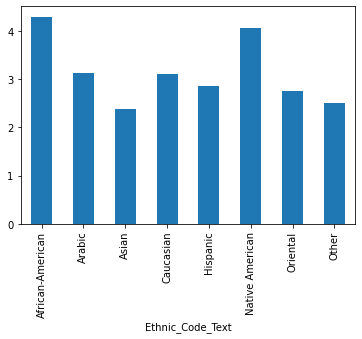

In [10]:
decile_by_race = df.groupby(['Ethnic_Code_Text'], sort=True)['DecileScore'].mean()
decile_by_race.plot(kind='bar')

<AxesSubplot:title={'center':'Mean Prior Count By Race'}, xlabel='Ethnic_Code_Text'>

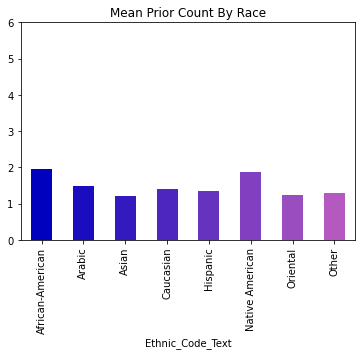

In [11]:
priors = df.groupby(['Ethnic_Code_Text'], sort=True)['RecSupervisionLevel'].mean()
my_colors = [(x/10.0, x/20.0, 0.75) for x in range(9)]
priors.plot(kind='bar', title='Mean Prior Count By Race', ylim=(0,6), color=my_colors)

## Data preparation

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60843 entries, 0 to 60842
Data columns (total 28 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Person_ID                60843 non-null  int64  
 1   AssessmentID             60843 non-null  int64  
 2   Case_ID                  60843 non-null  int64  
 3   Agency_Text              60843 non-null  object 
 4   LastName                 60843 non-null  object 
 5   FirstName                60843 non-null  object 
 6   MiddleName               15624 non-null  object 
 7   Sex_Code_Text            60843 non-null  object 
 8   Ethnic_Code_Text         60843 non-null  object 
 9   DateOfBirth              60843 non-null  object 
 10  ScaleSet_ID              60843 non-null  int64  
 11  ScaleSet                 60843 non-null  object 
 12  AssessmentReason         60843 non-null  object 
 13  Language                 60843 non-null  object 
 14  LegalStatus           

In [13]:
df = df.drop(['Person_ID', 'AssessmentID', 'Case_ID', 'LastName', 'FirstName', 'MiddleName', 'DateOfBirth', 'ScaleSet_ID', 'Screening_Date', 'Scale_ID', 'IsCompleted', 'IsDeleted', 'AssessmentType', 'ScoreText', 'RawScore'], axis=1)
df.head()

,Agency_Text,Sex_Code_Text,Ethnic_Code_Text,ScaleSet,AssessmentReason,Language,LegalStatus,CustodyStatus,MaritalStatus,RecSupervisionLevel,RecSupervisionLevelText,DisplayText,DecileScore
0,PRETRIAL,Male,Caucasian,Risk and Prescreen,Intake,English,Pretrial,Jail Inmate,Single,1,Low,Risk of Violence,4
1,PRETRIAL,Male,Caucasian,Risk and Prescreen,Intake,English,Pretrial,Jail Inmate,Single,1,Low,Risk of Recidivism,2
2,PRETRIAL,Male,Caucasian,Risk and Prescreen,Intake,English,Pretrial,Jail Inmate,Single,1,Low,Risk of Failure to Appear,1
3,PRETRIAL,Male,Caucasian,Risk and Prescreen,Intake,English,Pretrial,Jail Inmate,Married,1,Low,Risk of Violence,2
4,PRETRIAL,Male,Caucasian,Risk and Prescreen,Intake,English,Pretrial,Jail Inmate,Married,1,Low,Risk of Recidivism,1


In [14]:
encoder = preprocessing.LabelEncoder()
df["Agency_Text"] = encoder.fit_transform(df["Agency_Text"])
df["Sex_Code_Text"] = encoder.fit_transform(df["Sex_Code_Text"])
df["Ethnic_Code_Text"] = encoder.fit_transform(df["Ethnic_Code_Text"])
df["ScaleSet"] = encoder.fit_transform(df["ScaleSet"])
df["AssessmentReason"] = encoder.fit_transform(df["AssessmentReason"])
df["Language"] = encoder.fit_transform(df["Language"])
df["LegalStatus"] = encoder.fit_transform(df["LegalStatus"])
df["CustodyStatus"] = encoder.fit_transform(df["CustodyStatus"])
df["MaritalStatus"] = encoder.fit_transform(df["MaritalStatus"])
df["RecSupervisionLevelText"] = encoder.fit_transform(df["RecSupervisionLevelText"])
df["DisplayText"] = encoder.fit_transform(df["DisplayText"])
df.head()

,Agency_Text,Sex_Code_Text,Ethnic_Code_Text,ScaleSet,AssessmentReason,Language,LegalStatus,CustodyStatus,MaritalStatus,RecSupervisionLevel,RecSupervisionLevelText,DisplayText,DecileScore
0,2,1,3,1,0,0,5,0,4,1,1,2,4
1,2,1,3,1,0,0,5,0,4,1,1,1,2
2,2,1,3,1,0,0,5,0,4,1,1,0,1
3,2,1,3,1,0,0,5,0,1,1,1,2,2
4,2,1,3,1,0,0,5,0,1,1,1,1,1


In [15]:
X =df.drop(columns=['DecileScore'])
X.shape

(60843, 12)

In [16]:
y = df['DecileScore']
y.shape

(60843,)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

## Model

In [18]:
model = LogisticRegression(max_iter=1000)

In [19]:
model.fit(X_train, y_train)

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


LogisticRegression(max_iter=1000)

In [20]:
y_pred = model.predict(X_test)

In [21]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00        10
           1       0.42      0.92      0.58      4588
           2       1.00      0.00      0.00      2359
           3       0.12      0.08      0.10      2081
           4       0.18      0.03      0.06      1356
           5       0.14      0.03      0.05      1179
           6       0.14      0.24      0.18      1049
           7       0.15      0.00      0.01       879
           8       0.19      0.13      0.15       695
           9       0.33      0.38      0.35       601
          10       0.14      0.11      0.12       414

    accuracy                           0.33     15211
   macro avg       0.26      0.17      0.15     15211
weighted avg       0.37      0.33      0.23     15211



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [41]:
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

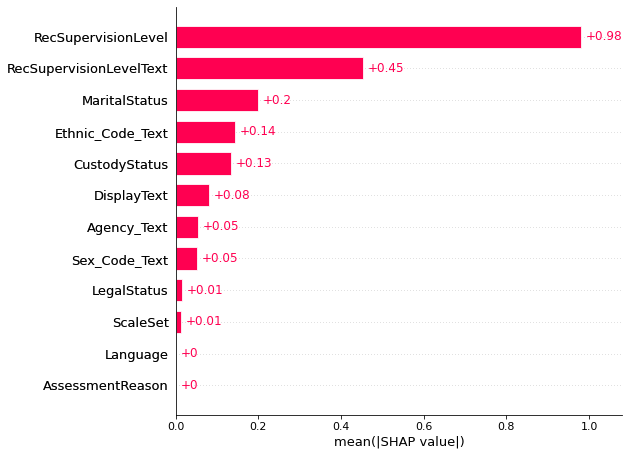

In [42]:
shap.plots.bar(shap_values[:, :, 1], max_display=13)

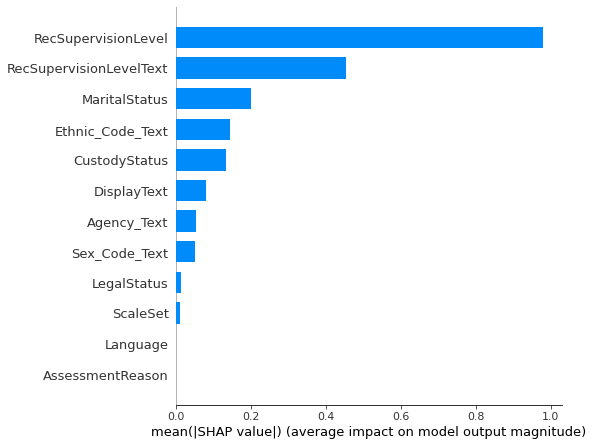

In [43]:
shap.summary_plot(shap_values[:, :, 1], X, plot_type="bar")